1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as la

In [2]:
N=2000
x1 = npr.randn(N)
x2 = x1+npr.randn(N)*3
x3 = 2*x1 + x2
x = np.zeros((3,N))
x[0,:]=x1
x[1,:]=x2
x[2,:]=x3

#eigenvectors eigenvalues of the covariance matrix
CovMat=np.cov(x)
l, P = la.eig(CovMat)
#SVD
U, spectrum, Vt = la.svd(CovMat)
#check if eigenvalues are equal
l=np.real_if_close(l)
print(np.allclose(np.sort(l), np.sort(spectrum)))
#check if eigenvectors are equal
print('P: \n',P)
print('U: \n',U)


True
P: 
 [[-0.11981385 -0.81649658  0.56478135]
 [-0.57189922 -0.40824829 -0.71152275]
 [-0.81152691  0.40824829  0.41803996]]
U: 
 [[-0.11981385  0.56478135 -0.81649658]
 [-0.57189922 -0.71152275 -0.40824829]
 [-0.81152691  0.41803996  0.40824829]]


The eigenvalue and SVD spectra coincide.
P and U matrix contain the same column vectors.

In [3]:
#dataset variability
Lambda=np.diag(np.sort(l))
print ("covariance matrix trace:", CovMat.trace())
print("eigenvalues:", Lambda[0,0], Lambda[1,1], Lambda[2,2])

print ('Fraction of variability explainde by one principal component is:',Lambda[2:3,2:3].trace()/Lambda.trace())
print ('Fraction of variability explainde by two principal components is:',Lambda[1:3,1:3].trace()/Lambda.trace())


covariance matrix trace: 29.45068115248955
eigenvalues: -3.523903634362009e-16 2.0150842806683773 27.435596871821172
Fraction of variability explainde by one principal component is: 0.9315776680941712
Fraction of variability explainde by two principal components is: 1.0000000000000002


With two principal components I get at least 99% variability. This is because the random variable x3 is linearly dependent on x1 and x2, so it does not contain information.

## Plots

In [4]:
print("eigenvalues", l)
print("eigenvector matrix \n", P)


eigenvalues [ 2.74355969e+01 -3.52390363e-16  2.01508428e+00]
eigenvector matrix 
 [[-0.11981385 -0.81649658  0.56478135]
 [-0.57189922 -0.40824829 -0.71152275]
 [-0.81152691  0.40824829  0.41803996]]


(-6.0, 6.0)

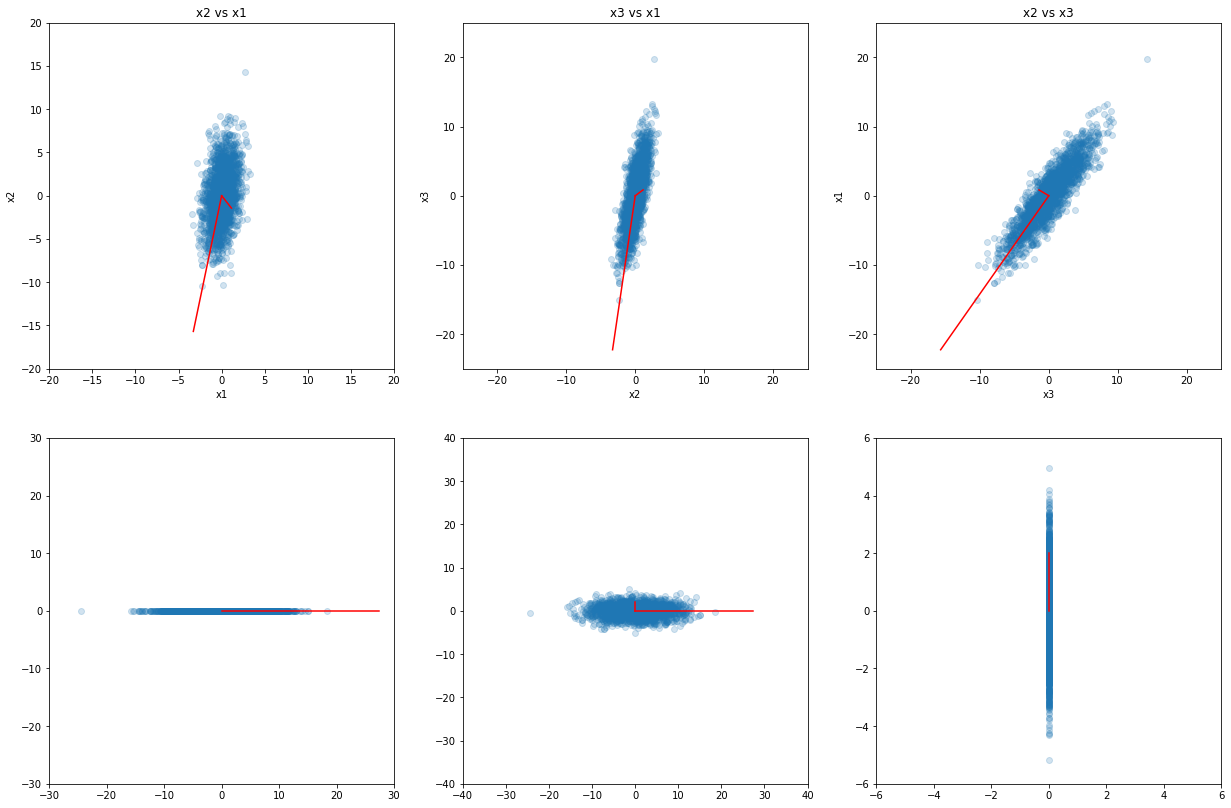

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(21,14))

#scatter data
axes[0,0].scatter(x[0,:],x[1,:],alpha=0.2)
axes[0,1].scatter(x[0,:],x[2,:],alpha=0.2)
axes[0,2].scatter(x[1,:],x[2,:],alpha=0.2)

#plot eigenvectors
scale_factor=1
axes[0,0].plot([0, scale_factor*P[0,0]*l[0]], [0, scale_factor*P[1,0]*l[0]], 'r-')
axes[0,0].plot([0, scale_factor*P[0,1]*l[1]], [0, scale_factor*P[1,1]*l[1]], 'r-')
axes[0,0].plot([0, scale_factor*P[0,2]*l[2]], [0, scale_factor*P[1,2]*l[2]], 'r-')

axes[0,1].plot([0, scale_factor*P[0,0]*l[0]], [0, scale_factor*P[2,0]*l[0]], 'r-')
axes[0,1].plot([0, scale_factor*P[0,1]*l[1]], [0, scale_factor*P[2,1]*l[1]], 'r-')
axes[0,1].plot([0, scale_factor*P[0,2]*l[2]], [0, scale_factor*P[2,2]*l[2]], 'r-')

axes[0,2].plot([0, scale_factor*P[1,0]*l[0]], [0, scale_factor*P[2,0]*l[0]], 'r-')
axes[0,2].plot([0, scale_factor*P[1,1]*l[1]], [0, scale_factor*P[2,1]*l[1]], 'r-')
axes[0,2].plot([0, scale_factor*P[1,2]*l[2]], [0, scale_factor*P[2,2]*l[2]], 'r-')

#titles and labels
axes[0,0].set_title("x2 vs x1")
axes[0,1].set_title("x3 vs x1")
axes[0,2].set_title("x2 vs x3")
axes[0,0].set_ylabel("x2")
axes[0,0].set_xlabel("x1")
axes[0,1].set_ylabel("x3")
axes[0,1].set_xlabel("x2")
axes[0,2].set_ylabel("x1")
axes[0,2].set_xlabel("x3")
#rescale axes
axes[0,0].set_xlim(-20,+20)
axes[0,0].set_ylim(-20,+20)
axes[0,1].set_xlim(-25,+25)
axes[0,1].set_ylim(-25,+25)
axes[0,2].set_xlim(-25,+25)
axes[0,2].set_ylim(-25,+25)


#rotation
Xp = np.dot(P.T,x)
I=np.diag([1]*3)

#scatter data
axes[1,0].scatter(Xp[0,:],Xp[1,:],alpha=0.2)
axes[1,1].scatter(Xp[0,:],Xp[2,:],alpha=0.2)
axes[1,2].scatter(Xp[1,:],Xp[2,:],alpha=0.2)

#plot eigenvectors
axes[1,0].plot([0, scale_factor*I[0,0]*l[0]], [0, scale_factor*I[1,0]*l[0]], 'r-')
axes[1,0].plot([0, scale_factor*I[0,1]*l[1]], [0, scale_factor*I[1,1]*l[1]], 'r-')
axes[1,0].plot([0, scale_factor*I[0,2]*l[2]], [0, scale_factor*I[1,2]*l[2]], 'r-')

axes[1,1].plot([0, scale_factor*I[0,0]*l[0]], [0, scale_factor*I[2,0]*l[0]], 'r-')
axes[1,1].plot([0, scale_factor*I[0,1]*l[1]], [0, scale_factor*I[2,1]*l[1]], 'r-')
axes[1,1].plot([0, scale_factor*I[0,2]*l[2]], [0, scale_factor*I[2,2]*l[2]], 'r-')

axes[1,2].plot([0, scale_factor*I[1,0]*l[0]], [0, scale_factor*I[2,0]*l[0]], 'r-')
axes[1,2].plot([0, scale_factor*I[1,1]*l[1]], [0, scale_factor*I[2,1]*l[1]], 'r-')
axes[1,2].plot([0, scale_factor*I[1,2]*l[2]], [0, scale_factor*I[2,2]*l[2]], 'r-')

#rescale axes
axes[1,0].set_xlim(-30,+30)
axes[1,0].set_ylim(-30,+30)
axes[1,1].set_xlim(-40,+40)
axes[1,1].set_ylim(-40,+40)
axes[1,2].set_xlim(-6,+6)
axes[1,2].set_ylim(-6,+6)


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [6]:
x= np.zeros((13,N))
x[0,:]=x1
x[1,:]=x2
x[2,:]=x3

for i in range(10):
    x[i+3,:] = npr.randn(N)/50
    
#eigenvectors eigenvalues of the covariance matrix
CovMat=np.cov(x)
l, P = la.eig(CovMat)
l
    
#dataset variability
Lambda=np.diag(np.sort(l))
print ("covariance matrix trace:", CovMat.trace())
print("eigenvalues:", np.sort(np.real(l)))

for i in range(1,len(l)):
    print ('Fraction of variability explainde by', i ,'principal components is:', np.real(Lambda[len(l)-i:,len(l)-i:].trace()/Lambda.trace()))


covariance matrix trace: 29.454658060766864
eigenvalues: [-1.03637380e-15  3.49151791e-04  3.60457539e-04  3.74675472e-04
  3.90042929e-04  3.91477683e-04  3.98204513e-04  4.16060749e-04
  4.22462490e-04  4.30816123e-04  4.40493265e-04  2.01508588e+00
  2.74355983e+01]
Fraction of variability explainde by 1 principal components is: 0.9314519380809418
Fraction of variability explainde by 2 principal components is: 0.9998650861080537
Fraction of variability explainde by 3 principal components is: 0.9998800410691445
Fraction of variability explainde by 4 principal components is: 0.9998946674865341
Fraction of variability explainde by 5 principal components is: 0.9999090102940259
Fraction of variability explainde by 6 principal components is: 0.99992313575929
Fraction of variability explainde by 7 principal components is: 0.9999366549966371
Fraction of variability explainde by 8 principal components is: 0.9999499458548178
Fraction of variability explainde by 9 principal components is: 0.99

The PCA analysis shows that one principal component contains about 93% of variability, while two principal components more than 99%, exactly as for ex 1. The other variables, as expected, don't contain relevant information, as they increase very poorly the variability of the system.

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [7]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
